In [2]:
!pip install transformers


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
print(tf.__version__)

import os
from os import listdir
from transformers import ( 
    T5Tokenizer, 
    TFT5ForConditionalGeneration
)
import numpy as np
import time

import pickle

# import python files
import sys
sys.path.append("../..")

from python_files.evaluation.mover_score import MoverScore, MyMoverScore
from python_files.evaluation.rouge_score import RougeScore
from python_files.language_tokens import LanguageTokens
from python_files.model_loader import ModelLoader
from python_files.output_tools.latex_table_writer import LatexTableWriter
from python_files.tf_record_loader import TFRecordLoader
from python_files.summary_generator import SummaryGenerator
# from python_files.summary_data import SummaryData

2.4.1


In [2]:
!nvidia-smi

Wed May  5 14:50:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:08:00.0  On |                  N/A |
| 38%   47C    P0    53W / 260W |   1111MiB / 11016MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Params

In [3]:
model_size = "t5-base"

MAX_ARTICLE_LEN = 512

MAX_HIGHLIGHT_LEN = 150

BATCH_SIZE = 8

root_folder = "../.."

result_folder = root_folder + "/results/"

## Language Tokens

In [4]:
tokenizer = T5Tokenizer.from_pretrained(model_size)
language_tokens = LanguageTokens(tokenizer, "tf")
prefix_size = language_tokens.prefix_size
language_token_order = ["de_de", "en_de", "de_en", "en_en"]

## Load data From Diretory

In [5]:
tf_record_loader = TFRecordLoader(root_folder, language_tokens, prefix_size, MAX_ARTICLE_LEN, MAX_HIGHLIGHT_LEN, BATCH_SIZE)

test_dataset = tf_record_loader.get_tfrecord_dataset("/data/sueddeutsche_test/")
test_dataset.prefetch(1024)

<PrefetchDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

In [10]:
val_dataset = tf_record_loader.get_tfrecord_dataset("/data/sueddeutsche_val/")
val_dataset.prefetch(1024)

<PrefetchDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

## Model Loader

In [11]:
model_loader = ModelLoader(model_size, root_folder+"/models", "t5_sueddeutsche") 
# model_loader.yield_models()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


## Score functions

In [12]:
mover_score = MoverScore()
def get_new_score_dicts():
    rouge_score_dict = {
        language_token_order[0]: RougeScore(),
        language_token_order[1]: RougeScore(),
        language_token_order[2]: RougeScore(),
        language_token_order[3]: RougeScore()
    }

    mover_score_dict = {
        language_token_order[0]: MyMoverScore(mover_score),
        language_token_order[1]: MyMoverScore(mover_score),
        language_token_order[2]: MyMoverScore(mover_score),
        language_token_order[3]: MyMoverScore(mover_score)
    }
    return rouge_score_dict, mover_score_dict
test = get_new_score_dicts()

In [13]:
def get_scores(data_dict, batch_size):
    results = []
    rouge_score_dict, mover_score_dict = get_new_score_dicts()
    for i, epoch in data_dict.items():
        mover_score_list = []
        batch_predicted = []
        batch_real = []
        
        j = 0
        for item in epoch:
            rouge_score_dict[item['language_tag']](item['real_data'], item['pred_data'])
            mover_score_dict[item['language_tag']](item['real_data'], item['pred_data'])
            
        results.append((rouge_score_dict.copy(), mover_score_dict.copy()))
        rouge_score_dict, mover_score_dict = get_new_score_dicts()
        print("Epoch: {} done".format(i))
    return results

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
 
class MyScore:
    def __init__(self)-> None:
        super().__init__()
        self.de_de = []
        self.de_en = []
        self.en_de = []
        self.en_en = []
        self.mover_score_de_de = []
        self.mover_score_de_en = []
        self.mover_score_en_de = []
        self.mover_score_en_en = []

        self.score_order = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
       
    def __call__(self, token, rouge_score, mover_score):
        if token == "de_de":
            self.de_de.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_de_de.append(mover_score)
        elif token == "de_en":
            self.de_en.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_de_en.append(mover_score)
        elif token == "en_de":
            self.en_de.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_en_de.append(mover_score)
        elif token == "en_en":
            self.en_en.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_en_en.append(mover_score)
        else:
            print("ERROR: token not known")
     
    @staticmethod
    def shift_array_right(x):
        zero_fill_up = np.zeros([1,x.shape[1]], dtype=np.float64)
        return np.concatenate([zero_fill_up, x])

    def plot_one(self, axs, title, arr):

        axs.set_title("ROUGE score: " + title)
        axs.set_ylim(0, 60)
        axs.set_xlim(1,12)
        
        arr = self.shift_array_right(arr)
        for j in range(3):
            axs.plot(arr[:,j], label=self.score_order[j])
        axs.legend()
 
    def plot(self):
        
        fig = plt.figure(constrained_layout=True, figsize=(12, 8))
        spec = plt.GridSpec(2, 3, figure=fig)
        f_ax1 = fig.add_subplot(spec[0, 0])
        f_ax2 = fig.add_subplot(spec[0, 1])
        f_ax3 = fig.add_subplot(spec[1, 0])
        f_ax4 = fig.add_subplot(spec[1, 1])
        self.plot_one(f_ax1, "DEtoDE", np.array(self.de_de))
        self.plot_one(f_ax2, "DEtoEN", np.array(self.de_en))
        self.plot_one(f_ax3, "ENtoDE", np.array(self.en_de))
        self.plot_one(f_ax4, "ENtoEN", np.array(self.en_en))
        
        f_ax5 = fig.add_subplot(spec[:, 2])
        f_ax5.set_title("Mover Score")
        f_ax5.set_xlim(1,12)
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_de_de), label="DEtoDE")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_de_en), label="DEtoEN")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_en_de), label="ENtoDE")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_en_en), label="ENtoEN")
        f_ax5.legend()
        plt.show()
        

        print("rouge_score max: ", "DEtoDE", np.argmax(np.array(self.de_de), axis=0))
        print("rouge_score max: ", "DEtoEN", np.argmax(np.array(self.de_en), axis=0))
        print("rouge_score max: ", "ENtoDE", np.argmax(np.array(self.en_de), axis=0))
        print("rouge_score max: ", "ENtoEN", np.argmax(np.array(self.en_en), axis=0))
        
    @staticmethod
    def append_to_lists(list1, list2, list3, item):
        
        list1.append(item[0])
        list2.append(item[1])
        list3.append(item[2])
    
    @staticmethod
    def get_propotion_of_baseline(x, baseline): 
        print(baseline, x)
        propotion = x / baseline 
        print(propotion)
        ret_list = []
        for x_i, p in zip(x, propotion):
            ret_list.append("{:.2f} ({:.2f})".format(x_i, p))
        return ret_list
        
    def get_latex_table(self, table_name, caption):
        print(self.mover_score_de_de[0])
        print(self.de_de[0])
        latex_table_dict = {
            'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'],
            'German to German':  list(self.de_de[0]) + [self.mover_score_de_de[0]],
            'English to English':  list(self.en_en[0]) +  [self.mover_score_en_en[0]],
            'English to German': self.get_propotion_of_baseline(self.en_de[0], self.de_de[0]) + [self.mover_score_en_de[0]],
            'German to English': self.get_propotion_of_baseline(self.de_en[0], self.en_en[0]) + [self.mover_score_de_en[0]]
        }
        print(latex_table_dict)
        latex_table_writer = LatexTableWriter()
        return latex_table_writer.write_table(table_name, latex_table_dict, caption) 
     

# Generation

## Generate Summarize
- Generate 240 / epoch

In [15]:
result_folder = root_folder + "/results/"
result_path = result_folder + "sued_epochs/"

In [16]:
skip_till_already_done = 12

for i, model in enumerate(model_loader.yield_models()):
    print("Epoch: ", i)
    if i < skip_till_already_done:
        print("Already done.")
    else:
        summary_gen = SummaryGenerator(tokenizer, language_token_order, False, epoch=i)
        predictions = summary_gen.generate_summaries(model, val_dataset, result_path, break_point=30)

../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-0.ckpt
Epoch:  0
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-1.ckpt
Epoch:  1
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-2.ckpt
Epoch:  2
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-3.ckpt
Epoch:  3
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-4.ckpt
Epoch:  4
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-5.ckpt
Epoch:  5
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-6.ckpt
Epoch:  6
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-7.ckpt
Epoch:  7
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-8.ckpt
Epoch:  8
Already done.
../../models/t5_sueddeutsche/t5_sueddeutsche_t5_base-9.ckpt
Epoch:  9
Already done.


## Load data from pickle file

In [17]:
predictions_dict = {}
epoch_files = listdir(result_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_path + file_name, "rb") as file:
        predictions_dict[i] = pickle.load(file)

In [18]:
mover_score = MoverScore()
scores = get_scores(predictions_dict, 16)

Epoch: 0 done
Epoch: 1 done
Epoch: 2 done
Epoch: 3 done
Epoch: 4 done
Epoch: 5 done
Epoch: 6 done
Epoch: 7 done
Epoch: 8 done
Epoch: 9 done


In [19]:
latex_table_writer = LatexTableWriter()

[0]----- de_de -----
rouge1 = 45.02, 95% confidence [40.79, 49.46]
rouge2 = 35.30, 95% confidence [30.61, 40.26]
rougeLsum = 41.37, 95% confidence [36.72, 45.57]
Moverscore: 0.67
[0]----- en_de -----
rouge1 = 33.92, 95% confidence [31.01, 36.98]
rouge2 = 18.28, 95% confidence [15.49, 20.87]
rougeLsum = 29.42, 95% confidence [26.66, 32.75]
Moverscore: 0.58
[0]----- de_en -----
rouge1 = 36.40, 95% confidence [33.85, 38.90]
rouge2 = 16.68, 95% confidence [14.60, 18.73]
rougeLsum = 30.76, 95% confidence [28.32, 33.29]
Moverscore: 0.57
[0]----- en_en -----
rouge1 = 47.40, 95% confidence [43.82, 51.40]
rouge2 = 34.80, 95% confidence [30.29, 39.83]
rougeLsum = 42.98, 95% confidence [39.07, 47.13]
Moverscore: 0.65
[1]----- de_de -----
rouge1 = 44.99, 95% confidence [40.53, 49.18]
rouge2 = 35.17, 95% confidence [30.12, 40.29]
rougeLsum = 41.38, 95% confidence [37.01, 46.09]
Moverscore: 0.66
[1]----- en_de -----
rouge1 = 35.68, 95% confidence [32.45, 38.80]
rouge2 = 19.92, 95% confidence [17.24,

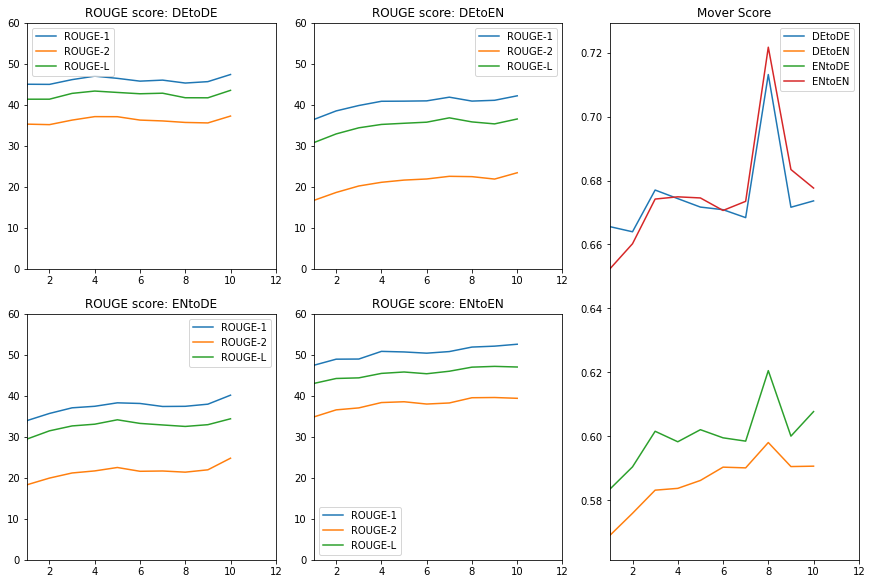

rouge_score max:  DEtoDE [9 9 9]
rouge_score max:  DEtoEN [9 9 6]
rouge_score max:  ENtoDE [9 9 9]
rouge_score max:  ENtoEN [9 8 8]


In [20]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        rouge_scores = rouge_score[token].result()
        mover_scores = mover_score[token].result()
        my_score(token, rouge_scores, mover_scores)

    
my_score.plot()

## Load Model with best rouge score

In [11]:
model = model_loader.load_epoch(9)
result_full_ds_path = result_folder + "sueddeutsche_full_ds/"

In [10]:
summary_gen = SummaryGenerator(tokenizer, language_token_order, True)

In [11]:
predictions = summary_gen.generate_summaries(model, test_dataset, result_full_ds_path, use_break_point=False)

[10]: time generating 10 batches: 336.6548249721527
[20]: time generating 10 batches: 290.0611569881439
[30]: time generating 10 batches: 286.54201769828796
[40]: time generating 10 batches: 293.94171929359436
[50]: time generating 10 batches: 300.61399507522583
[60]: time generating 10 batches: 277.2447452545166
[70]: time generating 10 batches: 289.9219825267792
[80]: time generating 10 batches: 297.69749116897583
[90]: time generating 10 batches: 282.3112347126007
[100]: time generating 10 batches: 297.6524040699005
[110]: time generating 10 batches: 317.2282917499542
[120]: time generating 10 batches: 289.2308373451233
[130]: time generating 10 batches: 303.1828784942627
[140]: time generating 10 batches: 299.8128945827484
[150]: time generating 10 batches: 273.94307827949524
[160]: time generating 10 batches: 280.41685724258423


## Load data and show result table

In [16]:
result_full_ds_path = result_folder + "sueddeutsche_full_ds/"
predictions_dict = {}
predictions = []

epoch_files = listdir(result_full_ds_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_full_ds_path + file_name, "rb") as file:
        [predictions.append(item) for item in pickle.load(file)]
        
predictions_dict[0] = predictions

In [10]:
scores = get_scores(predictions_dict, 16)

NameError: name 'get_scores' is not defined

In [14]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        my_score(token, rouge_score[token].result(), mover_score[token].result())

[0]----- de_de -----
rouge1 = 44.60, 95% confidence [43.89, 45.28]
rouge2 = 34.83, 95% confidence [34.10, 35.66]
rougeLsum = 41.39, 95% confidence [40.69, 42.11]
Moverscore: 0.67
[0]----- en_de -----
rouge1 = 37.14, 95% confidence [36.65, 37.65]
rouge2 = 21.38, 95% confidence [20.92, 21.90]
rougeLsum = 32.67, 95% confidence [32.14, 33.16]
Moverscore: 0.60
[0]----- de_en -----
rouge1 = 41.74, 95% confidence [41.25, 42.21]
rouge2 = 23.19, 95% confidence [22.72, 23.70]
rougeLsum = 36.09, 95% confidence [35.62, 36.60]
Moverscore: 0.59
[0]----- en_en -----
rouge1 = 48.77, 95% confidence [48.17, 49.38]
rouge2 = 35.93, 95% confidence [35.06, 36.75]
rougeLsum = 44.10, 95% confidence [43.37, 44.81]
Moverscore: 0.67


In [16]:
print(my_score.get_latex_table("Result scores of the 10th epoch test data from the sueddeutsche dataset.", "final_results_suedd"))

0.6733278286630188
[44.59784343 34.82641562 41.38861162]
[44.59784343 34.82641562 41.38861162] [37.14151917 21.38284366 32.67391949]
[0.83280976 0.61398347 0.78944227]
[48.76952065 35.92948336 44.10326938] [41.74264179 23.18926442 36.0857583 ]
[0.85591659 0.64541046 0.8182105 ]
{'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'], 'German to German': [44.59784342615355, 34.82641562284555, 41.38861162436015, 0.6733278286630188], 'English to English': [48.76952065106093, 35.929483362843314, 44.10326938172082, 0.6670944992125808], 'English to German': ['37.14 (0.83)', '21.38 (0.61)', '32.67 (0.79)', 0.6001814309064543], 'German to English': ['41.74 (0.86)', '23.19 (0.65)', '36.09 (0.82)', 0.5934178391549131]}
\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			Scores & German to German & English to English & English to German & German to English\\
			\hline\hline
			ROUGE-1 & 44.60 & 48.77 & 37.14 (0.83) & 41.74 (0.86)\\
			ROUGE-2 & 34.83 & 35.93 & 21.38 

In [31]:
model = model_loader.load_epoch(4)

In [32]:
summary_gen = SummaryGenerator(tokenizer, language_token_order, True)

In [33]:
predictions = summary_gen.generate_summaries(model, test_dataset, result_full_ds_path, use_break_point=False)

[10]: time generating 10 batches: 337.64810609817505
[20]: time generating 10 batches: 303.16109347343445
[30]: time generating 10 batches: 297.60018396377563
[40]: time generating 10 batches: 309.2587020397186
[50]: time generating 10 batches: 315.87124848365784
[60]: time generating 10 batches: 297.9181869029999
[70]: time generating 10 batches: 310.71748089790344
[80]: time generating 10 batches: 324.72355699539185
[90]: time generating 10 batches: 304.54825949668884
[100]: time generating 10 batches: 325.0870907306671
[110]: time generating 10 batches: 339.20445680618286
[120]: time generating 10 batches: 307.9210956096649
[130]: time generating 10 batches: 337.0630478858948
[140]: time generating 10 batches: 324.22000789642334
[150]: time generating 10 batches: 303.218478679657
[160]: time generating 10 batches: 296.4852364063263
[170]: time generating 10 batches: 318.9251263141632
[180]: time generating 10 batches: 301.10827898979187
[190]: time generating 10 batches: 318.8574173

In [17]:
result_full_ds_path = result_folder + "sueddeutsche_full_ds_epoch_3/"
predictions_dict = {}
predictions = []

epoch_files = listdir(result_full_ds_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_full_ds_path + file_name, "rb") as file:
        [predictions.append(item) for item in pickle.load(file)]
        
predictions_dict[0] = predictions

In [18]:
scores = get_scores(predictions_dict, 16)

Epoch: 0 done


In [19]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        my_score(token, rouge_score[token].result(), mover_score[token].result())

[0]----- de_de -----
rouge1 = 43.94, 95% confidence [43.19, 44.67]
rouge2 = 34.36, 95% confidence [33.55, 35.16]
rougeLsum = 40.73, 95% confidence [39.99, 41.45]
Moverscore: 0.67
[0]----- en_de -----
rouge1 = 36.19, 95% confidence [35.72, 36.67]
rouge2 = 20.54, 95% confidence [20.10, 21.04]
rougeLsum = 31.70, 95% confidence [31.23, 32.17]
Moverscore: 0.60
[0]----- de_en -----
rouge1 = 40.43, 95% confidence [39.95, 40.88]
rouge2 = 21.59, 95% confidence [21.11, 22.05]
rougeLsum = 34.67, 95% confidence [34.20, 35.17]
Moverscore: 0.59
[0]----- en_en -----
rouge1 = 48.15, 95% confidence [47.46, 48.81]
rouge2 = 35.38, 95% confidence [34.56, 36.16]
rougeLsum = 43.51, 95% confidence [42.83, 44.20]
Moverscore: 0.66


In [21]:
print(my_score.get_latex_table("Result scores of the 10th epoch test data from the sueddeutsche dataset.", "final_results_suedd"))

0.6699407912755636
[43.93609106 34.36141604 40.72508098]
[43.93609106 34.36141604 40.72508098] [36.19235874 20.53690221 31.70014408]
[0.82375008 0.59767334 0.77839364]
[48.15028143 35.38082938 43.507143  ] [40.4320146  21.59485576 34.66826886]
[0.83970464 0.61035471 0.79684085]
{'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'], 'German to German': [43.936091057191405, 34.36141604433348, 40.725080984812685, 0.6699407912755636], 'English to English': [48.15028143306964, 35.38082937761594, 43.50714299995598, 0.6640088368237089], 'English to German': ['36.19 (0.82)', '20.54 (0.60)', '31.70 (0.78)', 0.5964256827326373], 'German to English': ['40.43 (0.84)', '21.59 (0.61)', '34.67 (0.80)', 0.587371213176296]}
\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			Scores & German to German & English to English & English to German & German to English\\
			\hline\hline
			ROUGE-1 & 43.94 & 48.15 & 36.19 (0.82) & 40.43 (0.84)\\
			ROUGE-2 & 34.36 & 35.38 & 20.54 